# MultiClass Classification

## 1) Importing the libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

## 2) Checking for GPU

In [2]:
torch.cuda.is_available()

True

## 3) Data Preprocessing

In [3]:
df = pd.read_csv('drive/My Drive/Pytorch_DataSet/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
#Checking for null values in the columns

df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [5]:
# Checking the datatype of each column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## 4) Splitting the dataset into features and labels

In [6]:
X = df.drop('quality',axis = 1)
y = df['quality']
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [7]:
y

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

## 5) Conversion into train,val and test set

In [8]:
len(X), len(y)

(1599, 1599)

In [9]:
y.max(), y.min()

(8, 3)

In [10]:
X = torch.tensor(X.values,dtype=torch.float)
y = torch.LongTensor(y).reshape(-1,1)           # For softmax function, the label should be of Long Type

# As the value of y lies in range [3,8] and softmax function takes continous class input.
# So,first convert this in continous range i.e [0,n-1] ---> Here [0,5]
y = y - 3       #Corrected class = 0 to N-1 = 0 to 6-1(5)

X = X.cuda()
y = y.cuda()
type(X), type(y), y.dtype

(torch.Tensor, torch.Tensor, torch.int64)

In [11]:
y.min(), y.max() , y

(tensor(0, device='cuda:0'), tensor(5, device='cuda:0'), tensor([[2],
         [2],
         [2],
         ...,
         [3],
         [2],
         [3]], device='cuda:0'))

In [12]:
# we will take 80% as training data,val data, and test data
size = int(0.8*len(X)) 
val = int(0.1*len(X))
X_train, X_val, X_test = X[:size], X[size:size+val], X[size+val:] 
y_train, y_val, y_test = y[:size], y[size:size+val], y[size+val:] 
y_train.size(), y_train.dtype , y_train

(torch.Size([1279, 1]), torch.int64, tensor([[2],
         [2],
         [2],
         ...,
         [1],
         [3],
         [3]], device='cuda:0'))

## 6) Building the model

In [0]:
class ANN(nn.Module):
  
  def __init__(self,in_features,out_features,layers,p=0.4):

    super().__init__()
    
    self.bn_cont = nn.BatchNorm1d(in_features)
    self.softmax = nn.Softmax(dim=0)

    layerlist = []
    tracker = 0
    n_in = in_features
    for i in layers:
      layerlist.append(nn.Linear(n_in,i))
      layerlist.append(nn.ReLU(inplace=True))
      if tracker < 2:
        layerlist.append(nn.BatchNorm1d(i))
      layerlist.append(nn.Dropout(p))
      n_in = i
      tracker += 1

    layerlist.append(nn.Linear(layers[-1],out_features))      
    self.layers = nn.Sequential(*layerlist) 

  def forward(self,x):

    x = self.bn_cont(x)
    x = self.layers(x)
    x = self.softmax(x)
    return x

## 7) Initialising the model

In [14]:
model = ANN(X_train.shape[1],6,[400,300,200],p=0.3)
model

ANN(
  (bn_cont): BatchNorm1d(11, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (softmax): Softmax(dim=0)
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=400, out_features=300, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=300, out_features=200, bias=True)
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): Linear(in_features=200, out_features=6, bias=True)
  )
)

In [0]:
model = model.cuda() 

## 8) Defining the Loss function and Optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

## 9) Training the model

In [17]:
y_train = y_train.flatten()
y_val = y_val.flatten()
y_train.size(), y_val.size(), y_train.dtype

(torch.Size([1279]), torch.Size([159]), torch.int64)

In [18]:
epochs = 1001
losses = []

model.train()
for i in range(epochs):
  y_pred = model(X_train)
  #print(y_train.size(),y_pred.size(),y_train.dtype, y_pred.dtype)

  loss = criterion(y_pred,y_train)   #It should always be (predicted output,actual output,)

  losses.append(loss.item())

  if i%100 == 0:
    model.eval()
    val_y = model(X_val)
    losse = criterion(val_y,y_val)
    print(f'Epoch : {i}  Loss: {losse.item()}')
    model.train()

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


Epoch : 0  Loss: 1.7917526960372925
Epoch : 100  Loss: 1.7805254459381104
Epoch : 200  Loss: 1.7885749340057373
Epoch : 300  Loss: 1.7904877662658691
Epoch : 400  Loss: 1.785763144493103
Epoch : 500  Loss: 1.787887454032898
Epoch : 600  Loss: 1.78823983669281
Epoch : 700  Loss: 1.7883707284927368
Epoch : 800  Loss: 1.787732720375061
Epoch : 900  Loss: 1.7880293130874634
Epoch : 1000  Loss: 1.787436604499817


## 10) Plotting the graph between epochs and loss 

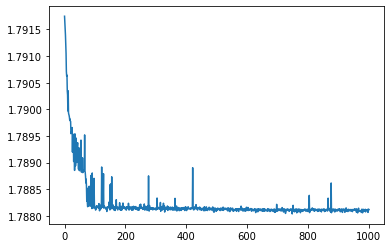

In [19]:
plt.plot(range(epochs),losses)

## 11) Predicting the output

In [20]:
y_test = y_test.flatten()
with torch.no_grad():
  model.eval()
  y_pred_test = model(X_test)
  loss = criterion(y_pred_test,y_test)

print(f'Loss : {loss.item()}')  

Loss : 1.7891032695770264


In [21]:
y_pred_test.shape, y_pred_test[:10]

(torch.Size([161, 6]),
 tensor([[4.9283e-07, 3.5246e-04, 1.3130e-07, 3.1752e-09, 5.0326e-05, 1.2952e-09],
         [1.3103e-07, 6.9498e-06, 1.9139e-08, 1.5791e-02, 9.3696e-04, 2.0234e-08],
         [9.0455e-08, 1.1554e-06, 1.3122e-08, 2.2916e-06, 5.0446e-03, 2.0234e-07],
         [6.8152e-08, 6.5457e-06, 2.6402e-06, 3.0107e-07, 1.9167e-03, 1.1138e-08],
         [6.6710e-08, 1.0542e-04, 4.2074e-08, 2.0371e-05, 3.4112e-04, 4.2800e-08],
         [4.8274e-08, 1.5004e-04, 2.7840e-09, 3.6138e-02, 8.5610e-04, 1.2952e-06],
         [1.2964e-07, 6.7041e-06, 1.7775e-08, 1.6503e-02, 9.4323e-04, 2.0519e-08],
         [6.8850e-08, 6.3632e-06, 2.4161e-06, 3.0706e-07, 1.9781e-03, 1.1422e-08],
         [6.6710e-08, 1.0542e-04, 4.2074e-08, 2.0371e-05, 3.4112e-04, 4.2800e-08],
         [3.0860e-08, 3.1639e-04, 4.6927e-08, 3.6903e-05, 2.4470e-04, 2.3753e-08]],
        device='cuda:0'))

In [22]:
values, indices = torch.max(y_pred_test, 1)
indices.dtype, indices

(torch.int64,
 tensor([1, 3, 4, 4, 4, 3, 3, 4, 4, 1, 1, 4, 4, 4, 3, 1, 4, 1, 1, 1, 4, 4, 3, 0,
         4, 4, 1, 1, 4, 0, 4, 1, 1, 4, 4, 3, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 1, 1,
         1, 4, 0, 4, 4, 0, 1, 2, 1, 4, 2, 4, 0, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 4,
         4, 1, 1, 1, 0, 0, 4, 3, 4, 1, 3, 1, 4, 3, 4, 4, 4, 4, 4, 1, 4, 0, 4, 1,
         4, 1, 1, 1, 4, 4, 4, 4, 1, 4, 4, 1, 4, 3, 4, 4, 1, 1, 4, 1, 0, 4, 1, 0,
         2, 2, 2, 2, 1, 1, 1, 3, 4, 1, 1, 3, 5, 4, 2, 5, 4, 4, 4, 4, 5, 1, 4, 1,
         0, 4, 4, 4, 4, 1, 4, 4, 3, 1, 3, 3, 1, 3, 3, 1, 4], device='cuda:0'))

In [0]:
y_test = y_test.cpu().numpy()
indices = indices.cpu().numpy()

In [24]:
indices = indices + 3
from sklearn.metrics import confusion_matrix
c = confusion_matrix(indices,y_test)
c

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  4,  5,  0,  0,  0,  0,  0],
       [ 2,  3, 28, 12,  1,  0,  0,  0,  0],
       [ 0,  0,  7,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  4, 12,  1,  0,  0,  0,  0],
       [ 1,  1, 23, 37, 13,  2,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0]])

In [25]:
print(y_test)
print(indices)

[2 3 4 3 2 2 3 3 2 2 2 5 4 4 4 2 3 3 3 2 2 4 3 1 3 3 2 2 4 1 4 0 2 2 3 2 2
 4 2 4 0 2 1 2 1 2 1 2 2 2 2 3 3 2 2 2 4 3 2 3 3 3 2 2 2 3 3 0 3 3 3 2 3 2
 3 3 3 3 2 3 2 2 3 1 2 2 3 2 3 3 3 3 3 2 3 2 4 3 3 3 2 2 3 4 3 3 4 3 2 2 2
 5 2 2 3 2 3 4 2 3 2 2 2 2 2 2 2 3 3 2 2 3 3 3 2 3 3 3 3 3 3 2 3 2 2 2 4 3
 3 3 3 2 3 3 3 3 2 3 3 2 3]
[4 6 7 7 7 6 6 7 7 4 4 7 7 7 6 4 7 4 4 4 7 7 6 3 7 7 4 4 7 3 7 4 4 7 7 6 7
 7 7 7 7 7 4 7 7 7 4 4 4 7 3 7 7 3 4 5 4 7 5 7 3 7 4 7 7 7 7 4 7 7 7 7 7 4
 4 4 3 3 7 6 7 4 6 4 7 6 7 7 7 7 7 4 7 3 7 4 7 4 4 4 7 7 7 7 4 7 7 4 7 6 7
 7 4 4 7 4 3 7 4 3 5 5 5 5 4 4 4 6 7 4 4 6 8 7 5 8 7 7 7 7 8 4 7 4 3 7 7 7
 7 4 7 7 6 4 6 6 4 6 6 4 7]


## 12) Plotting the curve for output

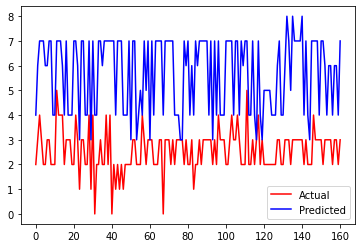

In [26]:
plt.plot(y_test,'r',label='Actual')
plt.plot(indices,'b',label='Predicted')
plt.legend()

<H1>Its efficiency can be increased by hyperparameter tuning</H1>

Try changing:
- No. Of epochs
- No. of hidden layers
- Learning rate
- No. of hidden nodes in each layer
- Normalization layers